In [109]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.optim as optim
import numpy as np

In [110]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [111]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/comsyshackathon5a/Task_A/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/comsyshackathon5a/Task_A/val', transform=val_transform)

# Calculate weights for each sample to handle imbalance
targets = train_dataset.targets
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


In [112]:
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [113]:
class_names = train_dataset.classes
print(class_names)

['female', 'male']


In [114]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# **ConvNext**

In [115]:

model_convnext = models.convnext_base(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [116]:
model_convnext.classifier[2] = nn.Linear(model_convnext.classifier[2].in_features, 1)


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model_convnext.to(device)

num_neg = class_counts[0]
num_pos = class_counts[1]
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [118]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import numpy as np


In [119]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=20):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")

        val_acc = evaluate_model(model, val_loader)

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved!")

        if scheduler:
            scheduler.step()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f'Validation Accuracy: {accuracy:.2f}%')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["female", "male"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy


Epoch 1, Train Loss: 0.1097
Validation Accuracy: 87.68%


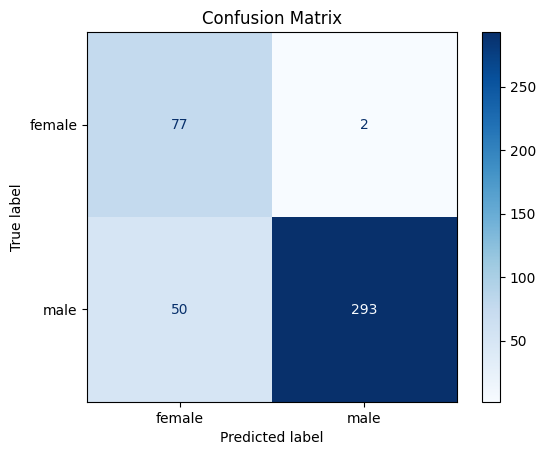

✅ Best model saved!
Epoch 2, Train Loss: 0.0388
Validation Accuracy: 91.94%


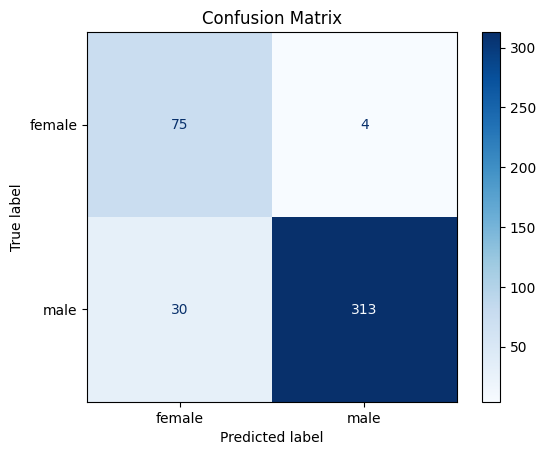

✅ Best model saved!
Epoch 3, Train Loss: 0.0276
Validation Accuracy: 90.28%


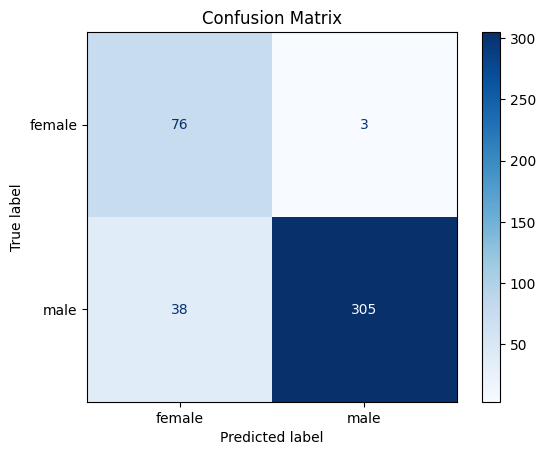

Epoch 4, Train Loss: 0.0200
Validation Accuracy: 93.36%


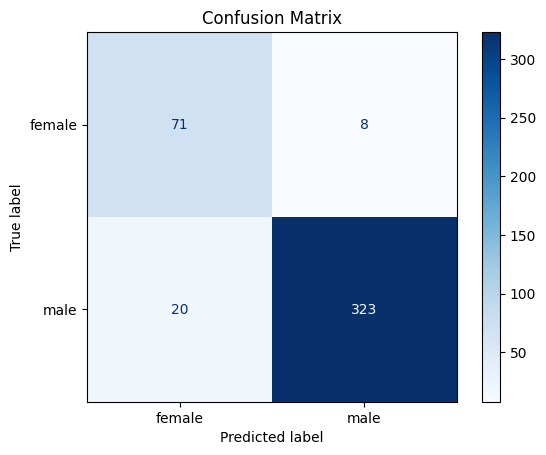

✅ Best model saved!
Epoch 5, Train Loss: 0.0135
Validation Accuracy: 92.89%


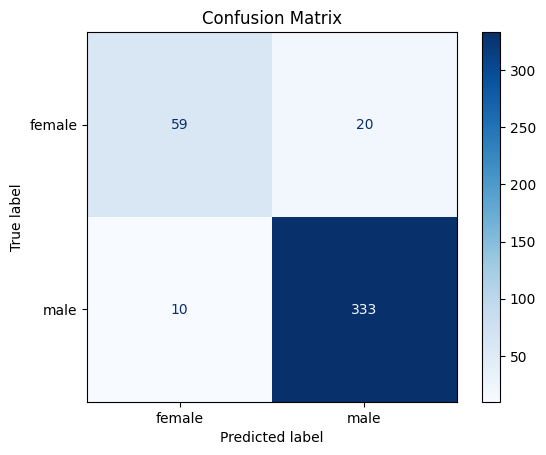

Epoch 6, Train Loss: 0.0082
Validation Accuracy: 91.71%


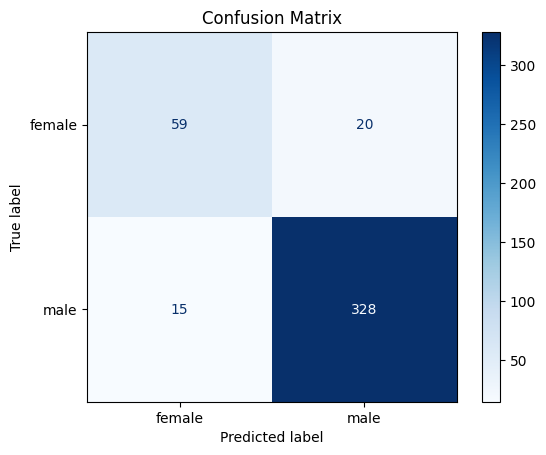

Epoch 7, Train Loss: 0.0102
Validation Accuracy: 92.42%


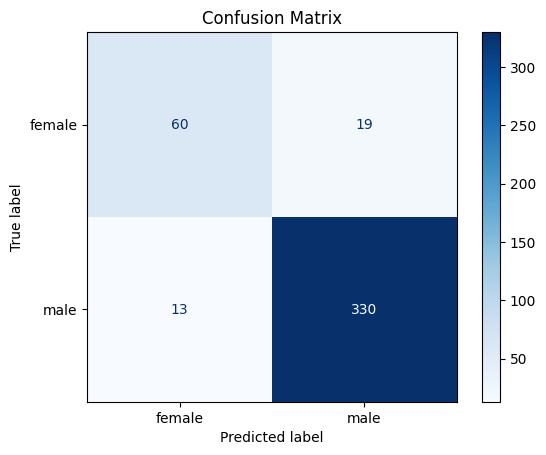

Epoch 8, Train Loss: 0.0043
Validation Accuracy: 91.71%


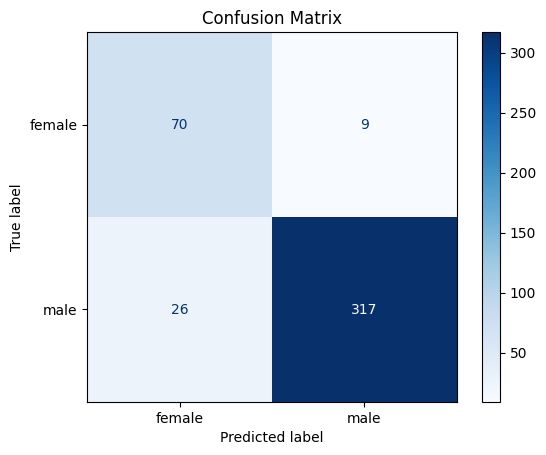

Epoch 9, Train Loss: 0.0114
Validation Accuracy: 91.71%


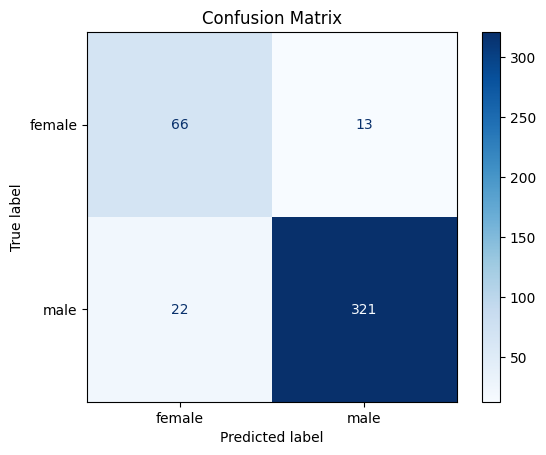

Epoch 10, Train Loss: 0.0063
Validation Accuracy: 93.13%


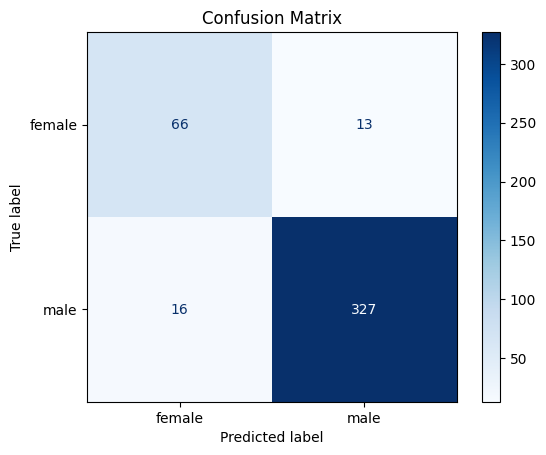

In [120]:
train_model(model_convnext, train_loader, val_loader, criterion, optimizer, num_epochs=10)

In [123]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_metrics(model, loader, split_name="Validation"):
    model.eval()
    preds = []
    labels_list = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float()

            outputs = model(images)
            probs = torch.sigmoid(outputs)
            predicted = (probs > 0.5).long()

            preds.extend(predicted.cpu().numpy())
            labels_list.extend(labels.long().cpu().numpy())

    acc = accuracy_score(labels_list, preds)
    prec = precision_score(labels_list, preds, zero_division=0)
    rec = recall_score(labels_list, preds, zero_division=0)
    f1 = f1_score(labels_list, preds, zero_division=0)

    print(f"\n📊 {split_name} Metrics (Best Model):")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

    cm = confusion_matrix(labels_list, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["female", "male"])
    disp.plot(cmap='Blues')
    plt.title(f"{split_name} Confusion Matrix")
    plt.show()



📊 Training Metrics (Best Model):
Accuracy : 0.9860
Precision: 1.0000
Recall   : 0.9723
F1 Score : 0.9860


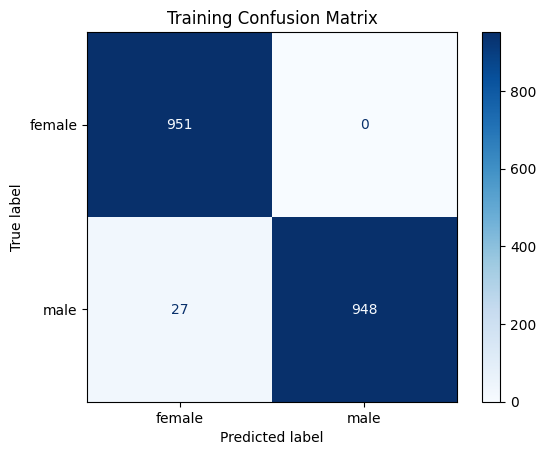


📊 Validation Metrics (Best Model):
Accuracy : 0.9336
Precision: 0.9758
Recall   : 0.9417
F1 Score : 0.9585


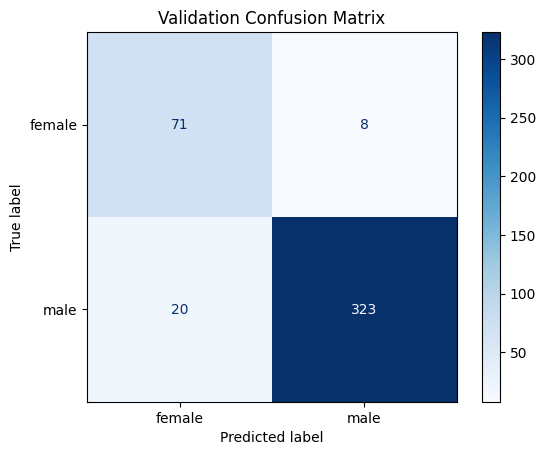

In [124]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# Evaluate
evaluate_metrics(model, train_loader, split_name="Training")
evaluate_metrics(model, val_loader, split_name="Validation")